Clean G140l spectrum, compare with photometry and phoenix model, make new version of the Ca H&K lines plot.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from scipy.interpolate import interp1d
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
import prepare_phoenix as pp


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
from astropy.convolution import convolve_fft
from astropy.convolution import Gaussian1DKernel

def smear(w,f, R, w_sample=2):
    '''
    Smears a model spectrum with a gaussian kernel to the given resolution, R.
    Adapeted from https://github.com/spacetelescope/pysynphot/issues/78

    Parameters
    -----------

    w,f:  spectrum to smear

    R: int
        The resolution (dL/L) to smear to

    w_sample: int
        Oversampling factor for smoothing

    Returns
    -----------

    sp: PySynphot Source Spectrum
        The smeared spectrum
    '''

    # Save original wavelength grid and units
    w_grid = w
    

    # Generate logarithmic wavelength grid for smoothing
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    n_w = np.size(w_grid)*w_sample
    w_log = np.logspace(w_logmin, w_logmax, num=n_w)

    # Find stddev of Gaussian kernel for smoothing
    R_grid = (w_log[1:-1]+w_log[0:-2])/(w_log[1:-1]-w_log[0:-2])/2
    sigma = np.median(R_grid)/R
    if sigma < 1:
        sigma = 1

    # Interpolate on logarithmic grid
    f_log = np.interp(w_log, w_grid, f)

    # Smooth convolving with Gaussian kernel
    gauss = Gaussian1DKernel(stddev=sigma)
    f_conv = convolve_fft(f_log, gauss)

    # Interpolate back on original wavelength grid
    f_sm = np.interp(w_grid, w_log, f_conv)

    # Write smoothed spectrum back into Spectrum object
    return w_grid, f_sm

In [3]:
def error_cut(w, f, e, bin_width = 30): #cut region before a rolling 30pt mean SN > 1
    sn = np.array([np.mean(f[i:i+bin_width]/e[i:i+bin_width]) for i in range(len(w[:-bin_width]))])
    start = w[:-bin_width][np.where(sn > 1)[0][0]]
    mask = (w > start) & (f > 0)
    return w[mask], f[mask], e[mask]


In [4]:
sdata = fits.getdata('../combined/odlm41010_sx1.fits',1)[0]
wo, fo, eo = sdata['WAVELENGTH'], sdata['FLUX'], sdata['ERROR']
#plt.step(wo, fo, where='mid')

mask = (wo <3345) | (wo > 3365) & (wo < 5321) | (wo > 5325) & (wo < 5476.5) | (wo > 5480.5) #cutting out overlap and cosmics
wo, fo, eo = wo[mask], fo[mask], eo[mask]


2888.3135622411687 5696.381658058151
3871.815639156187
147 204


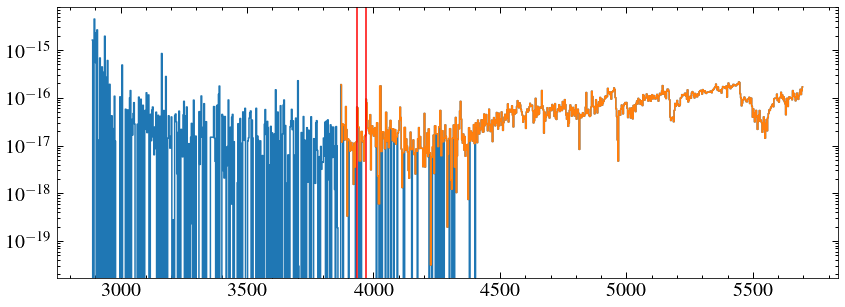

In [5]:
plt.step(wo, fo, where='mid')
print(wo[0], wo[-1])
wo2, fo2, eo2 = error_cut(wo, fo, eo)
plt.step(wo2, fo2, where='mid')
plt.yscale('log')
ca =[ 3933.6614, 3968.4673]
[plt.axvline(line, c='r') for line in ca]
print(wo2[0])

fc = fo[wo< wo2[0]]
print(len(fc[fc < 0]), len(fc[fc > 0] ))

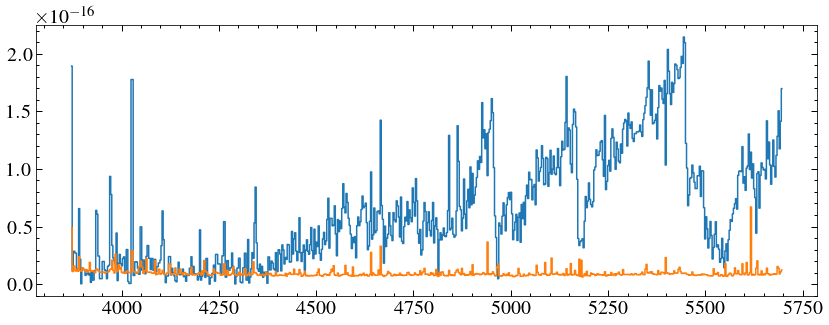

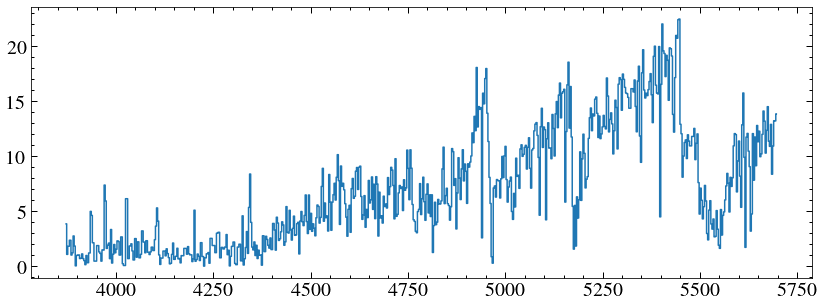

In [6]:
plt.step(wo2, fo2, where='mid')
plt.step(wo2, eo2, where='mid')
plt.show()
plt.step(wo2, fo2/eo2, where='mid')


In [7]:
phx = Table.read('interpolated_models/Trappist-1_g+19_phoenix_interpolated.ecsv')

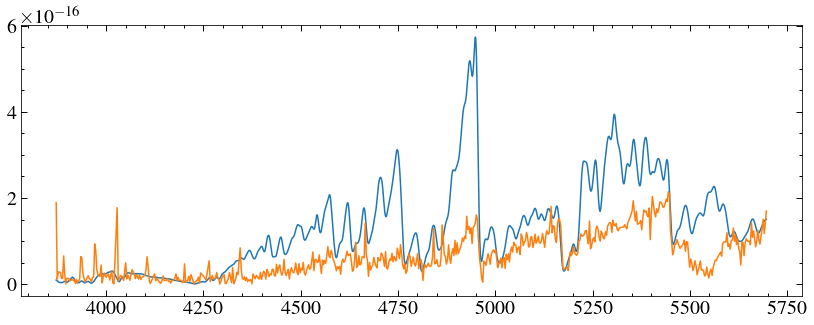

In [8]:
pw, pf = phx['WAVELENGTH'], phx['FLUX']*phx.meta['NORMFAC']
pws, pfs = smear(pw, pf, 1200)
pmask = (pws >= wo2[0]) & (pws <=wo2[-1])
pwo, pfo = pws[pmask], pfs[pmask]
plt.plot(pwo, pfo)
plt.plot(wo2, fo2)

PSg
8.685352059107001e-17 erg / (Angstrom cm2 s) 1.5999009742963939e-18 erg / (Angstrom cm2 s)
1.5417655778396646e-16 7.424687420088843e-17
7.424687420088843e-17 5.3820572742425385e-19
SDSSg
1.0082143520126394e-16 erg / (Angstrom cm2 s) 1.1143196819937384e-18 erg / (Angstrom cm2 s)
1.3152075679924724e-16 6.081981462317853e-17
6.081981462317853e-17 4.3061030594195756e-19
B
7.448702773736865e-17 erg / (Angstrom cm2 s) 1.3583807399408328e-17 erg / (Angstrom cm2 s)
8.535329366617469e-17 3.9260949087462016e-17
3.9260949087462016e-17 2.903504365182023e-19
[8.685352059107001e-17, 1.0082143520126394e-16, 7.448702773736865e-17]
[1.5999009742963939e-18, 1.1143196819937384e-18, 1.3583807399408328e-17]
[7.424687420088843e-17, 6.081981462317853e-17, 3.9260949087462016e-17]
[5.3820572742425385e-19, 4.3061030594195756e-19, 2.903504365182023e-19]
ratio [0.85485164 0.6032429  0.52708438]
ratio errors [0.01692234 0.00791797 0.09620061]


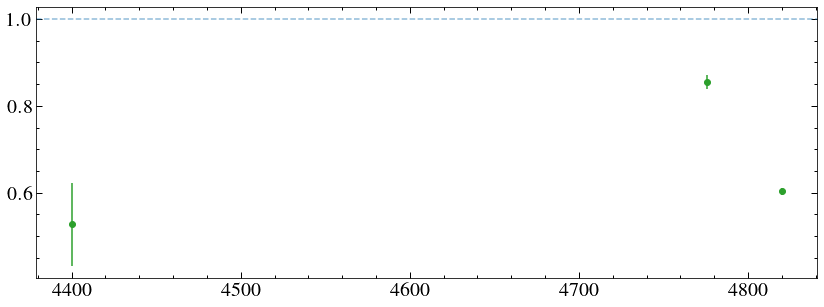

In [23]:
def make_phot(bp_w, bp_cc, w, f, e=0):
    mask = (w >= bp_w[0]) & (w <= bp_w[-1])
    w, f = w[mask], f[mask]
    bb_cci = interp1d(bp_w, bp_cc, fill_value='extrapolate')(w)
    flux = np.trapz(f*bb_cci, w)/np.trapz(bb_cci, w)
    if isinstance(e, int) != True:
        e = e[mask]
        intf = np.trapz(f, w)
        inte = (np.sum(e[1:]**2 * np.diff(w)**2))**0.5
        flux_error = (inte/intf)*flux
        return flux, flux_error
    else:
        return flux 

filter_path = '/home/david/work/filters/'
   
def mag_to_flux(mag_w, mag_f, mag_e, zp):
    mj = zp*10**(mag_f/-2.5)
    flux  = (mj*u.Jy).to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(mag_w*u.AA))
    flux_error = flux * mag_e * np.log(10) / 2.5
    return flux, flux_error

paths = ['{}{}/{}.dat'.format(filter_path, 'panstarrs', 'PS1.g'), '{}{}/{}.dat'.format(filter_path, 'sdss', 'g'), '{}{}/{}.dat'.format(filter_path, 'johnson', 'johnson_B')]    
    
bands = ['PSg', 'SDSSg', 'B']   
magws = [4775.62,4820,4400]
magfs = [19.35, 19.168, 19.8]
mages = [0.02, 0.012, 0.198]
zps = [3631, 3631, 4000.97]

phot_f = []
phot_e = []
stis_f = []
stis_e = []

ratios = []
ratio_errors = []

for i in range(len(bands)):
    print(bands[i])
    fb, eb = mag_to_flux(magws[i], magfs[i], mages[i], zps[i])
    print(fb, eb)
    bpw, bpcc = np.loadtxt(paths[i], unpack=True, usecols=(0,1))
    fphx = make_phot(bpw, bpcc, pwo, pfo)
    fstis, estis = make_phot(bpw, bpcc, wo2, fo2, eo2)
    print(fphx, fstis)
    print(fstis, estis)
    #plt.errorbar(magws[i], fb.value, yerr=eb.value, marker='o', c='C0')
    #plt.errorbar(magws[i], fphx, marker='o', c='C1')
    ratio = fstis/fb.value
    rat_e = ratio*((estis/fstis)**2+(eb.value/fb.value)**2)**0.5
    plt.errorbar(magws[i], ratio, yerr=rat_e, marker='o', c='C2')
    phot_f.append(fb.value)
    phot_e.append(eb.value)
    stis_f.append(fstis)
    stis_e.append(estis)
    ratios.append(ratio)
    ratio_errors.append(rat_e)
    
plt.axhline(1, ls='--', alpha=0.5)
#plt.show()

#bpath = '{}{}/{}.dat'.format(filter_path, 'sdss', 'g')
#bpath = '{}{}/{}.dat'.format(filter_path, 'johnson', 'johnson_B')

print(phot_f)
print(phot_e)
print(stis_f)
print(stis_e)
print('ratio', np.array(ratios))
print('ratio errors', np.array(ratio_errors))

(4300.0, 4400.0)

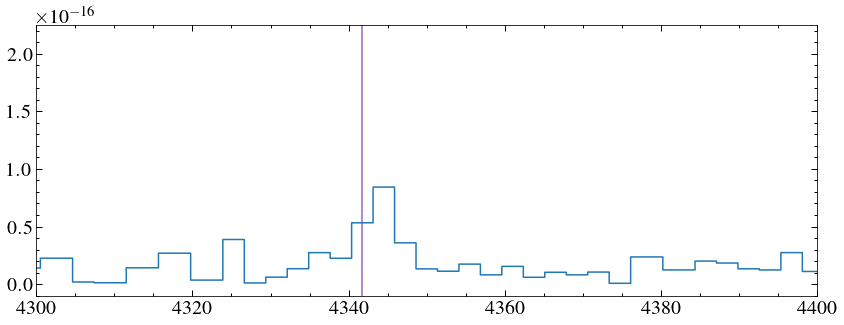

In [10]:
def air_to_vac(wavelength):
    """
    Implements the air to vacuum wavelength conversion described in eqn 65 of
    Griesen 2006
    """
    wlum = wavelength.to(u.um).value
    return (1+1e-6*(287.6155+1.62887/wlum**2+0.01360/wlum**4)) * wavelength

blines = [6562.79, 4861.35, 4340.472, 4101.734, 3970.075, 3889.064, 3835.397]
ca = np.array([ 3933.6614, 3968.4673])

cav= np.array([air_to_vac(line*u.AA).value for line in ca])
blv= np.array([air_to_vac(line*u.AA).value for line in blines])

[plt.axvline(line, c='C3') for line in cav]
[plt.axvline(line, c='C4') for line in blv[1:-1]]

plt.step(wo2, fo2, where='mid')
plt.xlim(wo2[0], 5000)

plt.xlim(4300, 4400)

In [11]:
wo2, fo2, eo2 = np.array(wo2), np.array(fo2), np.array(eo2)

6
3934.8364248192374 316.5606158829369 97.70476003108199


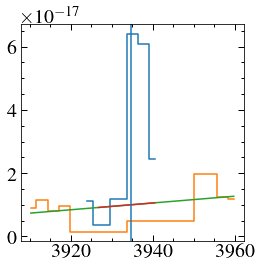

8
3969.65191408226 396.9852283498358 112.00966800762983


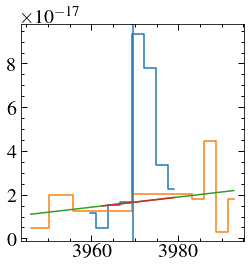

In [12]:
def wavelength_edges(w, gap=10):
    """
    Calulates w0 and w1, accounting for gaps induced by masking etc
    """
    diff = np.diff(w)
   # diff = np.insert(diff, 0, diff[0]) #adds an extravalue to make len(diff) = len(w)
    diff = np.insert(diff, (0, len(diff)), (diff[0], diff[-1])) #adds an extravalue to make len(diff) = len(w)+1
    w0 = []
    w1 = []
    for i, wi in enumerate(w):
        w0i, w1i = diff[i]/2, diff[i+1]/2
        if (max(w0i, w1i)/min(w0i, w1i)) > gap:
            w0i, w1i = min(w0i, w1i), min(w0i, w1i)
        w0.append(wi - w0i)
        w1.append(wi + w1i)
        
    return np.array(w0), np.array(w1)

dv = -60*u.km/u.s

edge = 11
cedge = 25

for i, line in enumerate(cav):
    #print(group)
    #line =  dv.to(u.AA, equivalencies=u.doppler_optical(line*u.AA)).value
    #print(group)

    linemask = (wo2 > line-edge) & (wo2 < line+edge)
    contmask = (wo2 > line-cedge) & (wo2 < line-edge) | (wo2 > line+edge) & (wo2 < line+cedge)
    lw, lf, le = wo2[linemask], fo2[linemask], eo2[linemask]
    print(len(lw))
    cfit = np.polyfit(wo2[contmask], fo2[contmask], 1)
    w0, w1 = wavelength_edges(lw)
    lineflux = np.sum((w1-w0)*lf)
    line_error = (np.sum(le**2 * (w1-w0)**2))**0.5
    cflux = np.sum((w1-w0)*np.polyval(cfit, lw))
    cerror = (line_error/abs(lineflux))*abs(cflux)
    flux = lineflux - cflux
    flux_error = (line_error**2+cerror**2)**0.5
    print(line, flux*1e18,flux_error*1e18)
  #  line_fluxes.append(flux)
  #  line_errors.append(flux_error)
   # line_names.append(np.unique(grouped_names[i]))
   # line_means.append(np.mean(rest_group))

    plt.figure(figsize=(4,4))
    plt.step(lw, lf, where='mid')
    plt.step(wo2[contmask], fo2[contmask], where='mid')
    plt.plot(wo2[contmask], np.polyval(cfit, wo2[contmask]))
    plt.plot(lw[1:], np.polyval(cfit, lw[1:]))

    #flux = ((2*np.pi)**0.5) * amp * std
   # print(len(group), flux/len(group))
    #mod_std = 0.1
    #model_amp =  (flux/len(group)) / (mod_std*((2*np.pi)**0.5)) 
   # print(model_amp)
    #model = models.Gaussian1D(model_amp, group[0], mod_std)
    #if len(group) > 1:
     #   for li in group[1:]:
   #         model = model + models.Gaussian1D(model_amp, li, mod_std)
    #plt.plot(lw, model(lw))
    plt.axvline(line)

    plt.show()

In [13]:
lw

array([3959.76829037, 3962.5167828 , 3965.26527281, 3968.01376033,
       3970.7622453 , 3973.51072765, 3976.25920732, 3979.00768425])

In [14]:
3934.8364248192374 361.5290013723594 66.57915163073878

SyntaxError: invalid syntax (<ipython-input-14-bc80500a6640>, line 1)